### Read Kv map from Figure 11 in Gregg and Carter (2011)

In [3]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import seaborn as sns
import scipy.misc as spy

In [4]:
image = spy.imread('Ascension_kv.png')

In [6]:
np.shape(image)

(3993, 4486, 4)

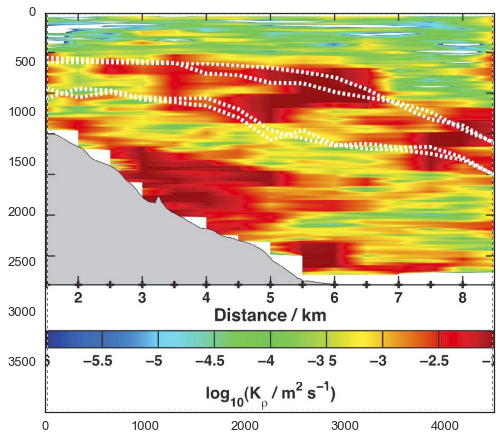

In [9]:
sns.set_style('white')
sns.set_context('talk')

plt.imshow(image)

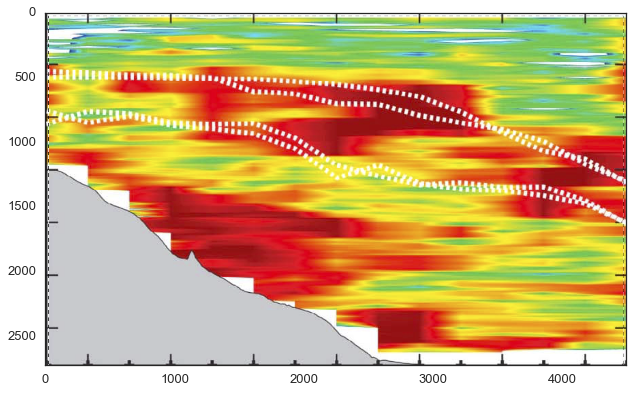

In [27]:
kvmap = image[:2720,:4486,:]
plt.imshow(kvmap)

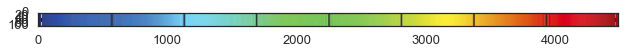

In [26]:
cbar = image[3200:3300,:4486,:]
plt.imshow(cbar)

Indices for the plot are [:2720,:4486,:]

Indices for the colormap [3200:3300,:4486,:]

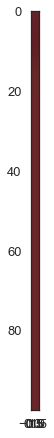

In [34]:
maxCM = cbar[:,4476:4478,:]
plt.imshow(maxCM)

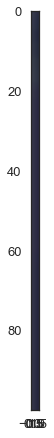

In [38]:
minCM = cbar[:,10:12,:]
plt.imshow(minCM)

I could normalize kvmap by min and max CM...